In [141]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab as p
from sklearn.cross_validation import KFold
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold

# Tree-based feature selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, f_classif, mutual_info_classif

pd.options.mode.chained_assignment = None


def import_data():
	# For .read_csv, always use header=0 when you know row 0 is the header row
	df = pd.read_csv("./data/ElectionsData-full.csv", header=0)

	df['split'] = 0
	indices = KFold(n=len(df), n_folds=5, shuffle=True)._iter_test_indices()
	df['split'][indices.next()] = 1
	df['split'][indices.next()] = 2
	raw_data = df.copy()

	raw_data[raw_data['split'] == 0].drop('split', axis=1).to_csv('./data/output/raw_train.csv', index=False, sep=',')
	raw_data[raw_data['split'] == 1].drop('split', axis=1).to_csv('./data/output/raw_test.csv', index=False, sep=',')
	raw_data[raw_data['split'] == 2].drop('split', axis=1).to_csv('./data/output/raw_validation.csv', index=False)

	return df


def export_transformed_data(_df):
	_df[_df['split'] == 0].drop('split', axis=1).to_csv('./data/output/processed_train.csv', index=False)
	_df[_df['split'] == 1].drop('split', axis=1).to_csv('./data/output/processed_test.csv', index=False)
	_df[_df['split'] == 2].drop('split', axis=1).to_csv('./data/output/processed_validation.csv', index=False)


def group_features(_df, _dic):
	_df = _df.dropna()
	all_features = _df.drop(['Vote', 'split'], axis=1).columns
	categorical_features = _df.drop(['Vote', 'split'], axis=1).select_dtypes(include=["object"])
	numeric_features = _df.drop(['Vote', 'split'], axis=1).select_dtypes(exclude=["object"])

	for column in _df.columns:
		_dic[column] = column

	return [all_features, categorical_features, numeric_features]


def fill_numeric_features(_df, features):
	for f in features:
		_df[f].fillna(_df[f].median(), inplace=True)


def fill_numeric_by_correlation(_df, factor, features):
	redundant_features = []
	cor = _df[features.columns].dropna().corr()
	print "We choose " + str(factor) + " correlation as correlated"
	indices = np.where(cor > factor)
	indices = [(cor.index[x], cor.columns[y]) for x, y in zip(*indices) if x != y and x < y]
	for pair in indices:
		fill_f1_with_f2(_df, pair[0], pair[1])
		redundant_features.append(pair[1])
	return redundant_features


def fill_f1_with_f2(_df, f1, f2):
	ratio = _df[f1].mean() / _df[f2].mean()
	print 'Filling ' + f1 + ' with ' + f2 + ' due to correlation'
	for index, row in _df[_df[f1].isnull()].iterrows():
		if ~np.isnan(_df[f2][index]):
			_df[f1][index] = _df[f2][index] * ratio

	ratio = _df[f2].mean() / _df[f1].mean()
	print 'Filling ' + f2 + ' with ' + f1 + ' due to correlation'
	for index, row in _df[_df[f2].isnull()].iterrows():
		if ~np.isnan(_df[f1][index]):
			_df[f2][index] = _df[f1][index] * ratio



def fill_categorical_features(_df, features):
	for f in features:
		for index, row in _df[_df[f].isnull()].iterrows():
			most_common = _df[(_df.Vote == row['Vote'])][f].value_counts().idxmax()
			_df.at[index, f] = most_common


def transform_categorical_features(_df, _dic, features):
	for f in features:
		_df[f] = _df[f].astype("category")
		_df[f + "_Int"] = _df[f].cat.rename_categories(range(_df[f].nunique())).astype(int)
		_df.loc[_df[f].isnull(), f + "_Int"] = np.nan  # fix NaN conversion3
		_dic[f + "_Int"] = f


def transform_label(_df, label):
	_df[label] = _df[label].astype("category").cat.rename_categories(range(_df[label].nunique())).astype(int)


def outliar_detection(_df, features):
	std_threshold = 3

	for f in features:
		std = _df[f].std()
		mean = _df[f].mean()
		_df[~_df[f].between(mean - std_threshold * std, mean + std_threshold * std)] = np.nan
	return _df


def scale_numeric(_df, features):
	for f in features:
		_df[f] = (_df[f] - _df[f].min()) / (_df[f].max() - _df[f].min())


def transform_bool(_df, name):
	_df[name] = _df[name].map({'No': -1, "Maybe": 0, 'Yes': 1}).astype(int)


def transform_category(_df, _dic, name):
	for cat in _df[name].unique():
		_df["Is_" + name + "_" + cat] = (_df[name] == cat).astype(int)
		_dic["Is_" + name + "_" + cat] = name
	del _df[name]


def transform_manual(_df, _dic):
	_df["Age_group"] = _df["Age_group"].map({'Below_30': 0, '30-45': 1, '45_and_up': 2}).astype(int)
	_df["Voting_Time"] = _df["Voting_Time"].map({'By_16:00': 0, 'After_16:00': 1}).astype(int)
	_df["Gender"] = _df["Gender"].map({'Male': -1, 'Female': 1}).astype(int)

	transform_bool(_df, "Looking_at_poles_results")
	transform_bool(_df, "Married")
	transform_bool(_df, "Financial_agenda_matters")
	transform_bool(_df, "Will_vote_only_large_party")
	transform_category(_df, _dic, "Most_Important_Issue")
	transform_category(_df, _dic, "Occupation")
	transform_category(_df, _dic, "Main_transportation")


def to_np_array(_df):
	df_data_X = _df.drop(['split', 'Vote'], axis=1).values
	df_data_Y = _df.Vote.values
	features_list = _df.drop(['split', 'Vote'], axis=1).columns
	return [df_data_X, df_data_Y, features_list]


def variance_filter(data_X, features_list):
	varsel = VarianceThreshold(threshold=0.01)
	varsel.fit_transform(data_X)
	featsel_idx = varsel.get_support()
	print 'Removing features with low variance - ', '\t', list(features_list[~featsel_idx])
	return list(features_list[~featsel_idx])


def select_features_with_rfe(data_X, data_Y, feature_names):
	result = []

	svc = SVC(kernel="linear", C=1)
	rfecv = RFECV(estimator=svc, step=1, cv=3, scoring='accuracy')
	rfecv.fit(data_X, data_Y)

	print("RFE - Optimal number of features : %d" % rfecv.n_features_)

	for idx, val in enumerate(rfecv.get_support()):
		if val:
			print "RFE - Choosing feature: " + feature_names[idx]
			result.append(feature_names[idx])
	return result


def univariate_features_with_mi(data_X, data_Y, feature_names):
	result = []

	selector = SelectPercentile(mutual_info_classif, percentile=25)
	selector.fit(data_X, data_Y)

	for idx, val in enumerate(selector.get_support()):
		if val:
			result.append(feature_names[idx])
			print "MI - Choosing feature: " + feature_names[idx]

	return result


def select_features_with_rfe_with_stratified_k_fold(data_X, data_Y, feature_names):
	result = []

	svc = SVC(kernel="linear", C=1)
	rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2), scoring='accuracy')
	rfecv.fit(data_X, data_Y)

	print("RFE stratified_k - Optimal number of features : %d" % rfecv.n_features_)

	for idx, val in enumerate(rfecv.get_support()):
		if val:
			print "RFE stratified_k - Choosing feature: " + feature_names[idx]
			result.append(feature_names[idx])
	return result


def univariate_features_with_f_classif(data_X, data_Y, feature_names):
	result = []

	selector = SelectPercentile(f_classif, percentile=25)
	selector.fit(data_X, data_Y)

	for idx, val in enumerate(selector.get_support()):
		if val:
			result.append(feature_names[idx])
			print "f-classif - Choosing feature: " + feature_names[idx]

	return result


def univariate_features_with_f_classif(data_X, data_Y, feature_names):
	result = []

	selector = SelectPercentile(f_classif, percentile=25)
	selector.fit(data_X, data_Y)

	for idx, val in enumerate(selector.get_support()):
		if val:
			result.append(feature_names[idx])
			print "f-classif - Choosing feature: " + feature_names[idx]

	return result


def embedded_features_by_descision_tree(data_X, data_Y, feature_names):
	result = []

	clf = ExtraTreesClassifier()
	clf = clf.fit(data_X, data_Y)
	tree_weights = clf.feature_importances_
	tree_weights /= tree_weights.max()
	tree_booleans = tree_weights > np.percentile(tree_weights, 75)
	for idx, val in enumerate(tree_booleans):
		if val:
			result.append(feature_names[idx])
			print "Tree Clasifier - Choosing feature: " + feature_names[idx]

	return result



redundant_features = []
useful_features = []
dic = {}




# Import the data

In [143]:
df = import_data()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 39 columns):
Vote                                             10000 non-null object
Occupation_Satisfaction                          9809 non-null float64
Avg_monthly_expense_when_under_age_21            9809 non-null float64
AVG_lottary_expanses                             9818 non-null float64
Most_Important_Issue                             9909 non-null object
Avg_Satisfaction_with_previous_vote              9829 non-null float64
Looking_at_poles_results                         9909 non-null object
Garden_sqr_meter_per_person_in_residancy_area    9794 non-null float64
Married                                          9929 non-null object
Gender                                           9928 non-null object
Voting_Time                                      9903 non-null object
Financial_balance_score_(0-1)                    9810 non-null float64
%Of_Household_Income                         

# Look at the Data

In [145]:
df.describe()

,Occupation_Satisfaction,Avg_monthly_expense_when_under_age_21,AVG_lottary_expanses,Avg_Satisfaction_with_previous_vote,Garden_sqr_meter_per_person_in_residancy_area,Financial_balance_score_(0-1),%Of_Household_Income,Avg_government_satisfaction,Avg_education_importance,Avg_environmental_importance,...,Weighted_education_rank,%_satisfaction_financial_policy,Avg_monthly_income_all_years,Last_school_grades,Number_of_differnt_parties_voted_for,Political_interest_Total_Score,Number_of_valued_Kneset_members,Overall_happiness_score,Num_of_kids_born_last_10_years,split
count,9809.000000,9809.000000,9818.000000,9829.000000,9794.000000,9810.000000,9813.000000,9806.000000,9823.000000,9783.000000,...,9797.000000,9802.000000,9824.000000,9835.000000,9835.000000,9805.000000,9816.000000,9822.000000,9795.000000,10000.00000
mean,5.511367,507.643792,67380.919408,169.002686,402.579462,0.500668,0.500361,4.987585,5.007205,5.003874,...,209.321953,49.823139,49720.908740,73.415353,1.998983,679.246658,10.003362,489.970994,0.662685,0.60000
std,2.855781,433.518917,69473.844694,144.476593,133.557107,0.288094,0.286215,2.895290,2.885800,2.893176,...,108.067552,29.111249,84550.825549,20.021796,1.252778,126.580099,2.775684,114.889986,1.039230,0.80004
min,1.000000,-855.714730,-166375.186748,-285.238243,1.511957,0.000078,0.000413,0.000001,0.000048,0.000591,...,7.141800,0.012620,9.832899,30.000000,0.000000,26.670526,5.000000,1.641626,0.000000,0.00000
25%,3.000000,199.225499,24420.519122,66.121900,307.042438,0.248523,0.255014,2.467898,2.524549,2.497779,...,130.719573,24.468975,4637.836638,60.000000,1.000000,603.732611,8.000000,420.440579,0.000000,0.00000
50%,6.000000,387.469720,48410.029203,128.670084,389.081350,0.500569,0.503486,4.996661,5.039814,4.958118,...,210.695887,49.709433,17013.740107,70.000000,2.000000,672.463176,10.000000,484.003063,0.000000,0.00000
75%,8.000000,708.293034,86099.873686,235.848891,479.527037,0.746059,0.743708,7.492286,7.467005,7.502315,...,262.212294,75.281457,56112.165912,90.000000,3.000000,767.770344,12.000000,562.308711,1.000000,1.00000
max,10.000000,2305.237140,560309.089996,768.412380,855.997552,0.999887,0.999597,9.999719,9.997036,9.999264,...,822.382848,99.984046,591235.998174,100.000000,7.000000,1060.929552,16.000000,810.486075,10.000000,2.00000


In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 39 columns):
Vote                                             10000 non-null object
Occupation_Satisfaction                          9809 non-null float64
Avg_monthly_expense_when_under_age_21            9809 non-null float64
AVG_lottary_expanses                             9818 non-null float64
Most_Important_Issue                             9909 non-null object
Avg_Satisfaction_with_previous_vote              9829 non-null float64
Looking_at_poles_results                         9909 non-null object
Garden_sqr_meter_per_person_in_residancy_area    9794 non-null float64
Married                                          9929 non-null object
Gender                                           9928 non-null object
Voting_Time                                      9903 non-null object
Financial_balance_score_(0-1)                    9810 non-null float64
%Of_Household_Income                         

## Map the features

In [154]:
all_features, categorical_features, numeric_features = group_features(df, dic)

print "### Categorical ###"
for f in  categorical_features.columns:
    print f

print
print
print
    
print "###  Numeric  ###"
for f in numeric_features.columns:
    print f



### Categorical ###
Most_Important_Issue
Looking_at_poles_results
Married
Gender
Voting_Time
Will_vote_only_large_party
Age_group
Main_transportation
Occupation
Financial_agenda_matters



###  Numeric  ###
Occupation_Satisfaction
Avg_monthly_expense_when_under_age_21
AVG_lottary_expanses
Avg_Satisfaction_with_previous_vote
Garden_sqr_meter_per_person_in_residancy_area
Financial_balance_score_(0-1)
%Of_Household_Income
Avg_government_satisfaction
Avg_education_importance
Avg_environmental_importance
Avg_Residancy_Altitude
Yearly_ExpensesK
%Time_invested_in_work
Yearly_IncomeK
Avg_monthly_expense_on_pets_or_plants
Avg_monthly_household_cost
Phone_minutes_10_years
Avg_size_per_room
Weighted_education_rank
%_satisfaction_financial_policy
Avg_monthly_income_all_years
Last_school_grades
Number_of_differnt_parties_voted_for
Political_interest_Total_Score
Number_of_valued_Kneset_members
Overall_happiness_score
Num_of_kids_born_last_10_years


### Unreasonable Data

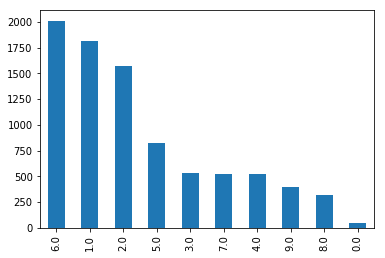

TypeError: Empty 'DataFrame': no numeric data to plot

In [188]:

df['Vote'].value_counts().plot(kind='bar')
p.show()

df[df["Avg_monthly_expense_when_under_age_21"] < 0].Vote.value_counts().plot(kind='bar')
p.title("Votes with Avg_monthly_expense_when_under_age_21 < 0")

### Find features with coorelation

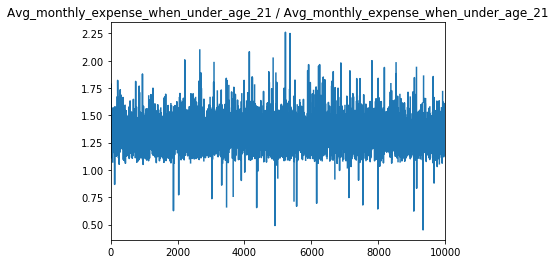

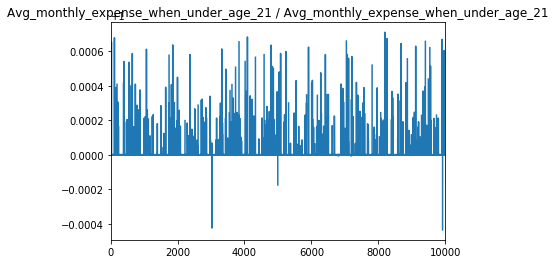

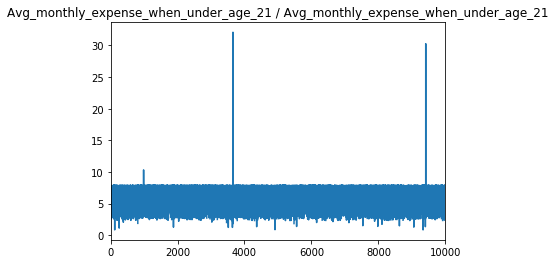

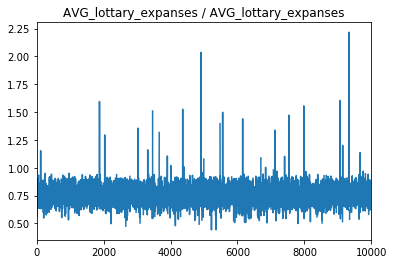

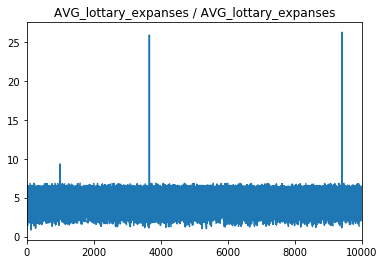

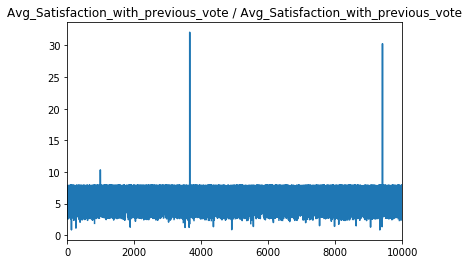

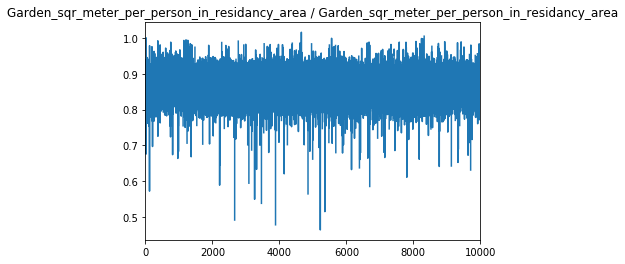

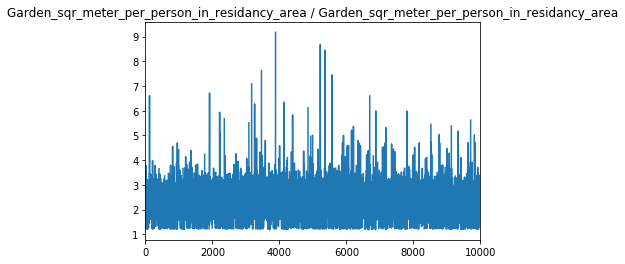

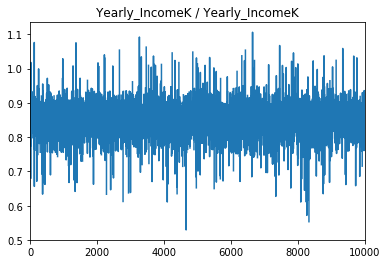

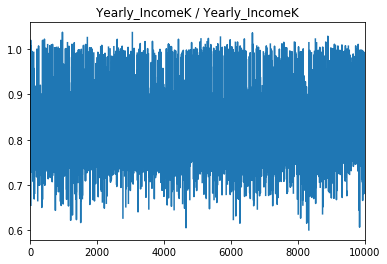

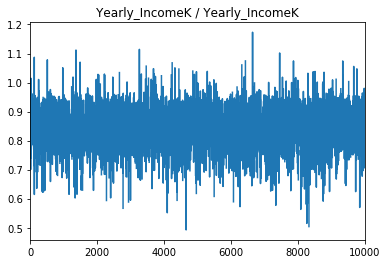

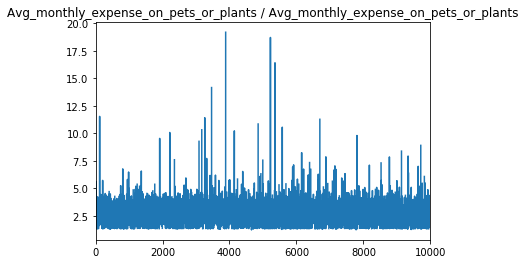

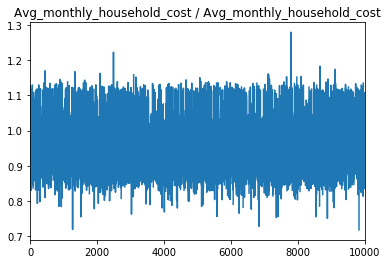

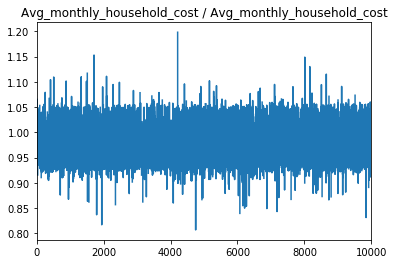

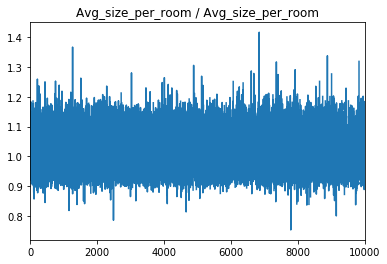

In [186]:
def print_coorlation(_df, factor, features):
    cor = _df[numeric_features.columns].dropna().corr()
    indices = np.where(cor > factor)
    indices = [(cor.index[x], cor.columns[y]) for x, y in zip(*indices) if x != y and x < y]
    for i in indices:
        _df['scaled'] = _df[i[0]] / _df[i[1]]
        _df['scaled'].plot()
        p.title("%s / %s" % (i[0], i[0]))
        p.show()

print_coorlation(df, 0.8, numeric_features)


In [183]:

df = import_data()

all_features, categorical_features, numeric_features = group_features(df, dic)
not_needed_features = fill_numeric_by_correlation(df, 0.95, numeric_features)
fill_numeric_by_correlation(df, 0.8, numeric_features)
print "# Added not_needed_features to redundant features"
redundant_features.extend(not_needed_features)

fill_numeric_features(df, numeric_features)
fill_categorical_features(df, categorical_features)
# transform_categorical_features(df, categorical_features)  # We Don't need that!!
transform_label(df, "Vote")
transform_manual(df, dic)

scale_numeric(df, numeric_features)
print "Before outliar detacction: " + str(df.shape[0])
df = outliar_detection(df, numeric_features)
print "After outliar detacction: " + str(df.shape[0])

print "## redundant features"
print redundant_features
df_no_NAN = df.drop(redundant_features, axis=1).dropna()

df_data_X, df_data_Y, features_list = to_np_array(df_no_NAN)
df_data_X = preprocessing.scale(df_data_X)

features_to_exclude = variance_filter(df_data_X, features_list)
redundant_features.extend(features_to_exclude)

good_features = select_features_with_rfe(df_data_X, df_data_Y, features_list)
print '# ADDED Features'
print list(set(good_features).difference(useful_features))
useful_features.extend(good_features)

good_features = select_features_with_rfe_with_stratified_k_fold(df_data_X, df_data_Y, features_list)
print '# ADDED Features'
print list(set(good_features).difference(useful_features))
useful_features.extend(good_features)

good_features = univariate_features_with_mi(df_data_X, df_data_Y, features_list)
print '# ADDED Features'
print list(set(good_features).difference(useful_features))
useful_features.extend(good_features)

good_features = univariate_features_with_f_classif(df_data_X, df_data_Y, features_list)
print '# ADDED Features'
print list(set(good_features).difference(useful_features))
useful_features.extend(good_features)

good_features = embedded_features_by_descision_tree(df_data_X, df_data_Y, features_list)
print '# ADDED Features'
print list(set(good_features).difference(useful_features))
useful_features.extend(good_features)

useful_features = list(set(useful_features))
print "### Useful features ###"
print useful_features

print "### Redundant features ###"
print redundant_features

print "### Final features ###"
print list(set(useful_features).difference(redundant_features))

export_transformed_data(df[useful_features + ['Vote']])

base_feature = map(lambda x: dic[x], useful_features)
print "### Base features ###"
print list(set(base_feature))



We choose 0.95 correlation as correlated
Filling Avg_monthly_expense_when_under_age_21 with Avg_Satisfaction_with_previous_vote due to correlation
Filling Avg_Satisfaction_with_previous_vote with Avg_monthly_expense_when_under_age_21 due to correlation
Filling Garden_sqr_meter_per_person_in_residancy_area with Avg_monthly_expense_on_pets_or_plants due to correlation
Filling Avg_monthly_expense_on_pets_or_plants with Garden_sqr_meter_per_person_in_residancy_area due to correlation
Filling Garden_sqr_meter_per_person_in_residancy_area with Phone_minutes_10_years due to correlation
Filling Phone_minutes_10_years with Garden_sqr_meter_per_person_in_residancy_area due to correlation
Filling Yearly_IncomeK with Avg_monthly_household_cost due to correlation
Filling Avg_monthly_household_cost with Yearly_IncomeK due to correlation
Filling Yearly_IncomeK with Avg_size_per_room due to correlation
Filling Avg_size_per_room with Yearly_IncomeK due to correlation
Filling Avg_monthly_expense_on_pets

KeyboardInterrupt: 

In [142]:
df.describe()

,Occupation_Satisfaction,Avg_monthly_expense_when_under_age_21,AVG_lottary_expanses,Avg_Satisfaction_with_previous_vote,Garden_sqr_meter_per_person_in_residancy_area,Financial_balance_score_(0-1),%Of_Household_Income,Avg_government_satisfaction,Avg_education_importance,Avg_environmental_importance,...,Avg_size_per_room,Weighted_education_rank,%_satisfaction_financial_policy,Avg_monthly_income_all_years,Last_school_grades,Number_of_differnt_parties_voted_for,Political_interest_Total_Score,Number_of_valued_Kneset_members,Overall_happiness_score,Num_of_kids_born_last_10_years
count,9809.000000,9998.000000,9818.000000,9829.000000,10000.000000,9810.000000,9813.000000,9806.000000,9823.000000,9783.000000,...,9806.000000,9797.000000,9802.000000,9824.000000,9835.000000,9835.000000,9805.000000,9816.000000,9822.000000,9795.000000
mean,5.511367,507.237186,67380.919408,169.002686,402.737706,0.500668,0.500361,4.987585,5.007205,5.003874,...,20.737681,209.321953,49.823139,49720.908740,73.415353,1.998983,679.246658,10.003362,489.970994,0.662685
std,2.855781,432.999768,69473.844694,144.476593,133.312993,0.288094,0.286215,2.895290,2.885800,2.893176,...,2.847497,108.067552,29.111249,84550.825549,20.021796,1.252778,126.580099,2.775684,114.889986,1.039230
min,1.000000,-855.714730,-166375.186748,-285.238243,1.511957,0.000078,0.000413,0.000001,0.000048,0.000591,...,1.092153,7.141800,0.012620,9.832899,30.000000,0.000000,26.670526,5.000000,1.641626,0.000000
25%,3.000000,198.995231,24420.519122,66.121900,307.492373,0.248523,0.255014,2.467898,2.524549,2.497779,...,19.506124,130.719573,24.468975,4637.836638,60.000000,1.000000,603.732611,8.000000,420.440579,0.000000
50%,6.000000,386.730751,48410.029203,128.670084,389.204208,0.500569,0.503486,4.996661,5.039814,4.958118,...,20.779797,210.695887,49.709433,17013.740107,70.000000,2.000000,672.463176,10.000000,484.003063,0.000000
75%,8.000000,708.287357,86099.873686,235.848891,479.287391,0.746059,0.743708,7.492286,7.467005,7.502315,...,22.268272,262.212294,75.281457,56112.165912,90.000000,3.000000,767.770344,12.000000,562.308711,1.000000
max,10.000000,2305.237140,560309.089996,768.412380,855.997552,0.999887,0.999597,9.999719,9.997036,9.999264,...,28.671832,822.382848,99.984046,591235.998174,100.000000,7.000000,1060.929552,16.000000,810.486075,10.000000


RFE stratified_k - Optimal number of features : 23
RFE stratified_k - Choosing feature: AVG_lottary_expanses
RFE stratified_k - Choosing feature: Avg_Satisfaction_with_previous_vote
RFE stratified_k - Choosing feature: Looking_at_poles_results
RFE stratified_k - Choosing feature: Garden_sqr_meter_per_person_in_residancy_area
RFE stratified_k - Choosing feature: Married
RFE stratified_k - Choosing feature: Yearly_IncomeK
RFE stratified_k - Choosing feature: Avg_monthly_expense_on_pets_or_plants
RFE stratified_k - Choosing feature: Avg_monthly_household_cost
RFE stratified_k - Choosing feature: Will_vote_only_large_party
RFE stratified_k - Choosing feature: Phone_minutes_10_years
RFE stratified_k - Choosing feature: Avg_size_per_room
RFE stratified_k - Choosing feature: Weighted_education_rank
RFE stratified_k - Choosing feature: Last_school_grades
RFE stratified_k - Choosing feature: Political_interest_Total_Score
RFE stratified_k - Choosing feature: Number_of_valued_Kneset_members
RFE 

['AVG_lottary_expanses',
 'Avg_Satisfaction_with_previous_vote',
 'Looking_at_poles_results',
 'Garden_sqr_meter_per_person_in_residancy_area',
 'Married',
 'Yearly_IncomeK',
 'Avg_monthly_expense_on_pets_or_plants',
 'Avg_monthly_household_cost',
 'Will_vote_only_large_party',
 'Phone_minutes_10_years',
 'Avg_size_per_room',
 'Weighted_education_rank',
 'Last_school_grades',
 'Political_interest_Total_Score',
 'Number_of_valued_Kneset_members',
 'Overall_happiness_score',
 'Is_Most_Important_Issue_Environment',
 'Is_Most_Important_Issue_Social',
 'Is_Most_Important_Issue_Military',
 'Is_Most_Important_Issue_Financial',
 'Is_Most_Important_Issue_Education',
 'Is_Most_Important_Issue_Other',
 'Is_Most_Important_Issue_Foreign_Affairs']

[('Avg_monthly_expense_when_under_age_21',
  'Avg_Satisfaction_with_previous_vote'),
 ('Garden_sqr_meter_per_person_in_residancy_area',
  'Avg_monthly_expense_on_pets_or_plants'),
 ('Garden_sqr_meter_per_person_in_residancy_area', 'Phone_minutes_10_years'),
 ('Yearly_IncomeK', 'Avg_monthly_household_cost'),
 ('Yearly_IncomeK', 'Avg_size_per_room'),
 ('Avg_monthly_expense_on_pets_or_plants', 'Phone_minutes_10_years'),
 ('Avg_monthly_household_cost', 'Political_interest_Total_Score')]

   Avg_monthly_expense_when_under_age_21  Avg_Satisfaction_with_previous_vote  \
0                             520.295896                           173.431965   
1                             695.412346                           231.804115   
2                             102.471366                                  NaN   
3                             392.898135                           130.966045   
4                            1825.062431                           608.354144   
5                             540.959917                           180.319972   
6                             295.794850                            98.598283   
7                              60.152418                            20.050806   
8                             217.746310                            72.582103   
9                            -284.978409                           -94.992803   

     x         y  
0  3.0  3.001356  
1  3.0  3.001356  
2  NaN  3.001356  
3  3.0  3.001356  
4  3.0  3.001

0       3.0
1       3.0
2       NaN
3       3.0
4       3.0
5       3.0
6       3.0
7       3.0
8       3.0
9       3.0
10      3.0
11      3.0
12      3.0
13      3.0
14      3.0
15      3.0
16      3.0
17      3.0
18      3.0
19      3.0
20      3.0
21      3.0
22      3.0
23      3.0
24      3.0
25      3.0
26      3.0
27      3.0
28      3.0
29      3.0
       ... 
9970    3.0
9971    3.0
9972    3.0
9973    NaN
9974    3.0
9975    3.0
9976    3.0
9977    3.0
9978    3.0
9979    3.0
9980    3.0
9981    3.0
9982    3.0
9983    3.0
9984    3.0
9985    3.0
9986    3.0
9987    3.0
9988    3.0
9989    3.0
9990    3.0
9991    3.0
9992    3.0
9993    3.0
9994    3.0
9995    3.0
9996    3.0
9997    3.0
9998    3.0
9999    3.0
Name: x, Length: 10000, dtype: float64